# Apple Music Data Project

This project focuses on a dataset which was requested from apple data privacy and includes various information in relation to my music listening. The aim of the project is to find interesting insights into my music listening habits.

This type of data can be requested from apple provided a valid apple ID is used. The data can then be requested from their 'Data and Privacy' page. 

The project works with two different types of dataset: My library data (data about the songs in my library) and my listening data (data about how I listen to my library since I started using the streaming service)

Readying the workspace with 'imports' and such

In [192]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
import string
from datetime import datetime
import pytz

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.family'] = 'Gill Sans MT'
saved_style_state = matplotlib.rcParams.copy()

The data project will go through two datasets to see what my library looks like and how I listen to it. The datasets are:
1. Library data (data about the songs in my apple music library)
2. Listening data (data about my listening habits and activity since I got apple music in 2016)

In [214]:
#Importing datasets into workspace
csv_filepath = 'Apple Music Play Activity.csv'
listening_data = pd.read_csv(csv_filepath, parse_dates=['Event Start Timestamp'])

json_tracks_filepath = 'Apple Music Library Tracks.json'
library_data = pd.read_json(json_tracks_filepath, convert_dates=['Date Added To Library', 'Release Date'])


Let's learn a bit about what's in my library

In [197]:
#Cleaning up the data set from columns in 'NaN'
library_data = library_data.drop(library_data.columns[32:len(library_data.columns)], axis=1)     
pd.options.display.max_columns = None
library_data.sample(2)


,Content Type,Track Identifier,Title,Sort Name,Artist,Sort Artist,Is Part of Compilation,Album,Sort Album,Album Artist,Genre,Track Year,Track Number On Album,Track Count On Album,Disc Number Of Album,Disc Count Of Album,Track Duration,Track Play Count,Date Added To Library,Date Added To iCloud Music Library,Last Modified Date,Last Played Date,Skip Count,Date of Last Skip,Is Purchased,Audio File Extension,Is Checked,Copyright,Release Date,Purchased Track Identifier,Apple Music Track Identifier,Composer
1726,Song,182888966,Pathetic (feat. Naah),Pathetic (feat. Naah),Ninajirachi,Ninajirachi,False,Lapland,Lapland,Ninajirachi,Electronic,2018,5,7,1,1,220463,0,2019-02-15 05:06:27+00:00,2019-02-15T05:06:27Z,2019-02-15T05:06:27Z,NaN,0,NaN,False,m4a,False,℗ 2019 Ninajirachi under exclusive license to ...,2018-08-31 05:00:00+00:00,1.449454e+09,1.449454e+09,"Nina Wilson, Hanna Westlin, David Kjellstrand ..."
641,Song,182869026,guidance,guidance,Travis Scott,Travis Scott,False,Birds in the Trap Sing McKnight,Birds in the Trap Sing McKnight,Travis Scott,Hip-Hop/Rap,2016,13,14,1,1,207107,6,2016-09-19 23:33:16+00:00,2016-09-19T23:33:16Z,2016-09-19T23:33:16Z,2018-03-05T21:03:04Z,5,2018-04-26T01:05:01Z,False,m4a,False,"℗ 2016 Epic Records, a division of Sony Music ...",2016-09-02 00:00:00+00:00,1.150136e+09,1.150136e+09,"Jacques Webster, Kashief ""K. Forest"" Hanson & ..."


In [54]:
library_data.columns

Index(['Content Type', 'Track Identifier', 'Title', 'Sort Name', 'Artist',
       'Sort Artist', 'Is Part of Compilation', 'Album', 'Sort Album',
       'Album Artist', 'Genre', 'Track Year', 'Track Number On Album',
       'Track Count On Album', 'Disc Number Of Album', 'Disc Count Of Album',
       'Track Duration', 'Track Play Count', 'Date Added To Library',
       'Date Added To iCloud Music Library', 'Last Modified Date',
       'Last Played Date', 'Skip Count', 'Date of Last Skip', 'Is Purchased',
       'Audio File Extension', 'Is Checked', 'Copyright', 'Release Date',
       'Purchased Track Identifier', 'Apple Music Track Identifier',
       'Composer', 'Month'],
      dtype='object')

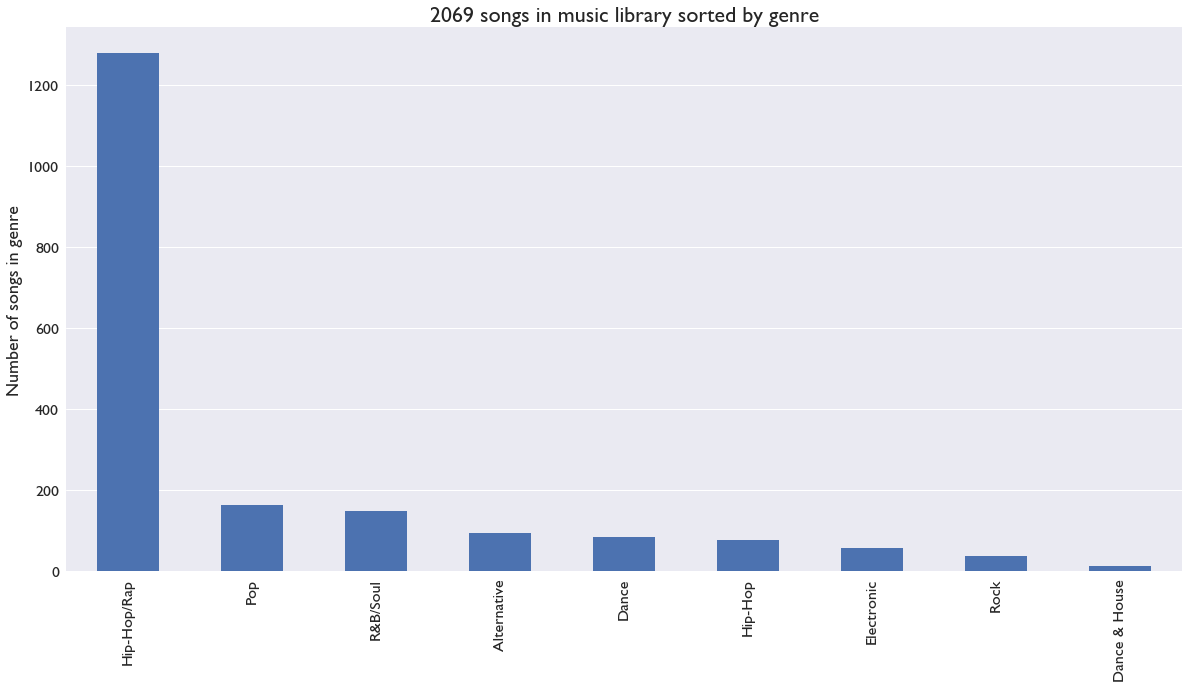

In [154]:
def library_genre():
    genre_bar = library_data["Genre"].value_counts()
    genre_bar[genre_bar > 10].plot(kind='bar')
    plt.ylabel('Number of songs in genre', fontsize=18, fontfamily='Gill Sans MT')
    plt.title('{} songs in music library sorted by genre'.format(str(len(library_data['Title']))),              fontsize=22, fontfamily='Gill Sans MT')
    plt.xticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.axes().yaxis.grid()
    plt.style.use('seaborn-dark')
    return plt.show()

library_genre()

<function matplotlib.pyplot.show(*args, **kw)>

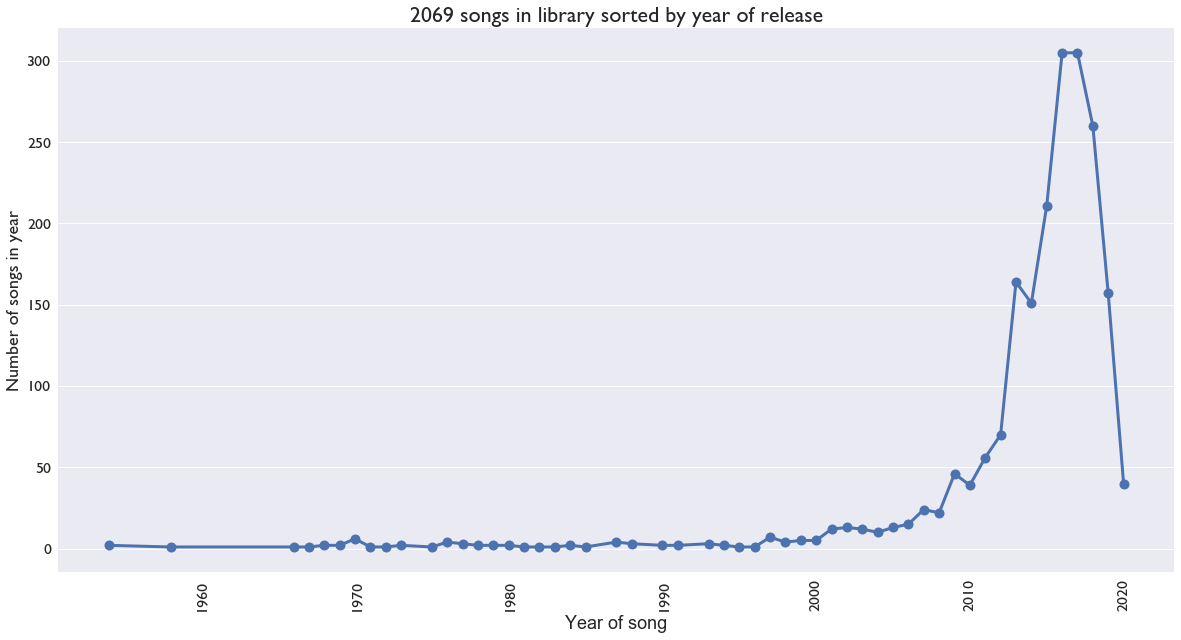

In [156]:
music_year = library_data['Track Year'][library_data['Track Year'] != 0].value_counts().sort_index().plot(marker= 'o', markersize=10, linewidth=3)
plt.xlabel('Year of song', fontsize=18)
plt.ylabel('Number of songs in year', fontsize=18, fontfamily='Gill Sans MT')
plt.title('{} songs in library sorted by year of release'.format(len(library_data['Track Year'])), fontsize=22, fontfamily='Gill Sans MT')
plt.xticks(fontsize=16, fontfamily='Gill Sans MT')
plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
plt.axes().yaxis.grid()
plt.show

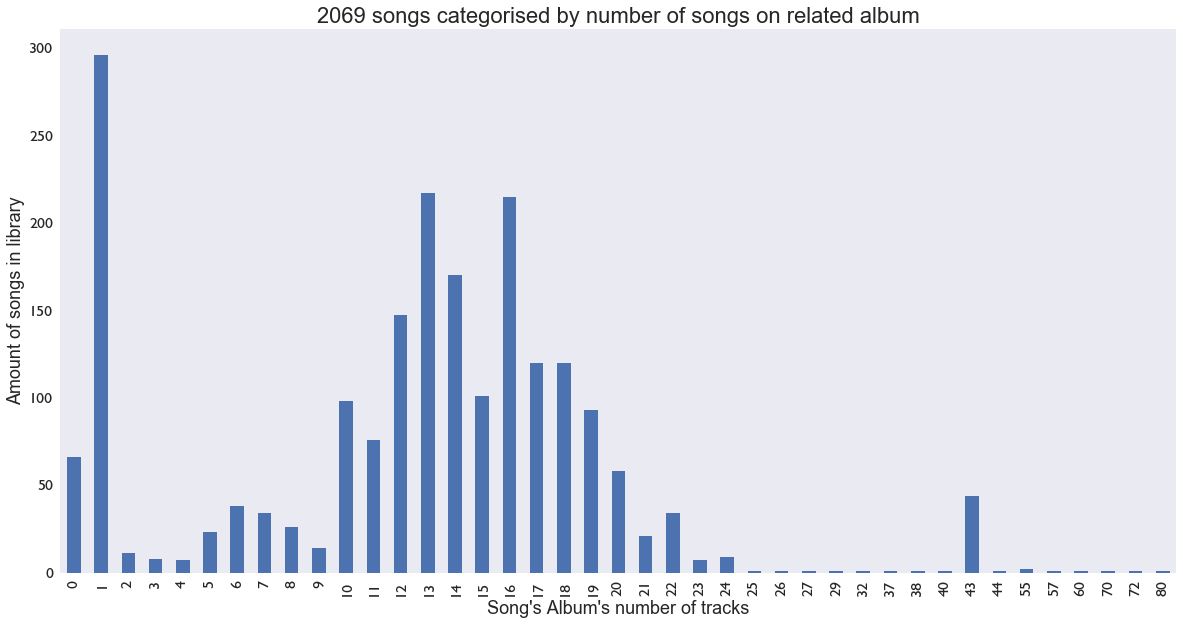

In [163]:
def song_project_track_numbers():
    library_data['Track Count On Album'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel("Song's Album's number of tracks", fontsize=18)
    plt.ylabel("Amount of songs in library", fontsize=18)
    plt.title('{} songs categorised by number of songs on related album'.format(len(library_data)),             fontsize=22)
    plt.xticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
    
song_project_track_numbers()

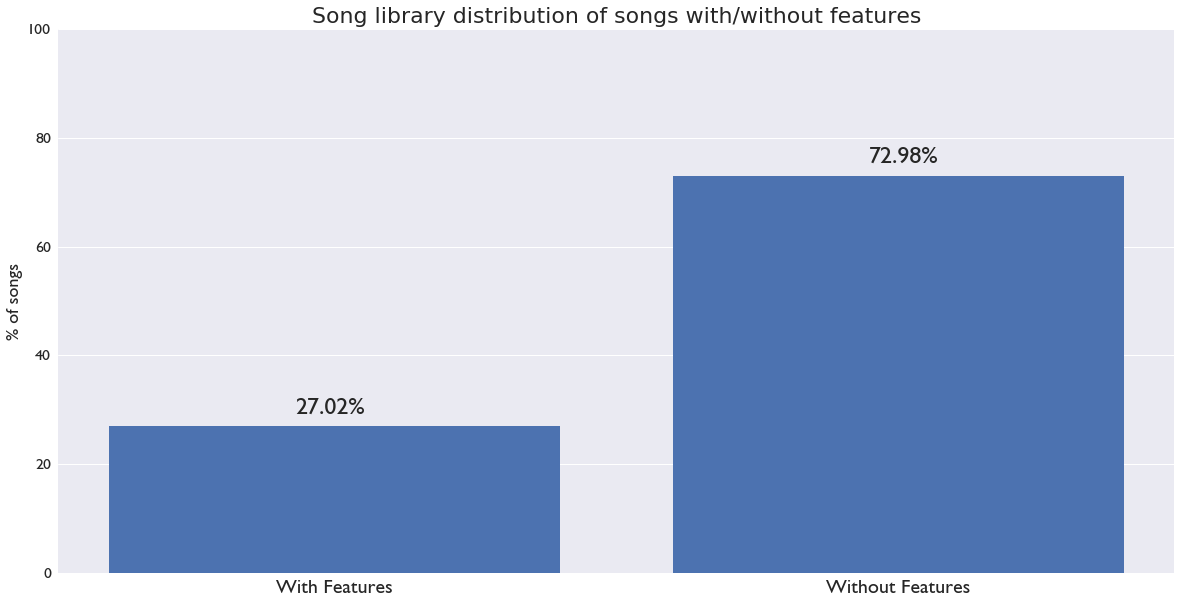

In [186]:
def song_features():
    features = ['feat.' in song for song in library_data['Title']]
    true_count = 0
    false_count = 0
    for i in features:
        if i == True:
            true_count += 100/2069
        if i == False:
            false_count += 100/2069
    x_titles = ['With Features', 'Without Features']
    feature_count = [true_count, false_count]
    x_pos = [i for i, _ in enumerate(x_titles)]
    plt.ylim(0, 100)
    plt.bar(x_pos, feature_count)
    plt.xticks(x_pos, x_titles, fontsize=20, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.annotate(str('%.2f' % true_count) + '%', xy=(0.25,0.315), xycoords='figure fraction', fontsize=24,      fontfamily='Gill Sans MT')
    plt.annotate(str('%.2f' % false_count) + '%', xy=(0.735,0.73), xycoords='figure fraction', fontsize=24,     fontfamily='Gill Sans MT')
    plt.ylabel('% ' + 'of songs', fontsize=18, fontfamily='Gill Sans MT')
    plt.title('Song library distribution of songs with/without features', fontsize=22, fontfamily='Gill         Sans MT')
    plt.axes().yaxis.grid()

song_features()

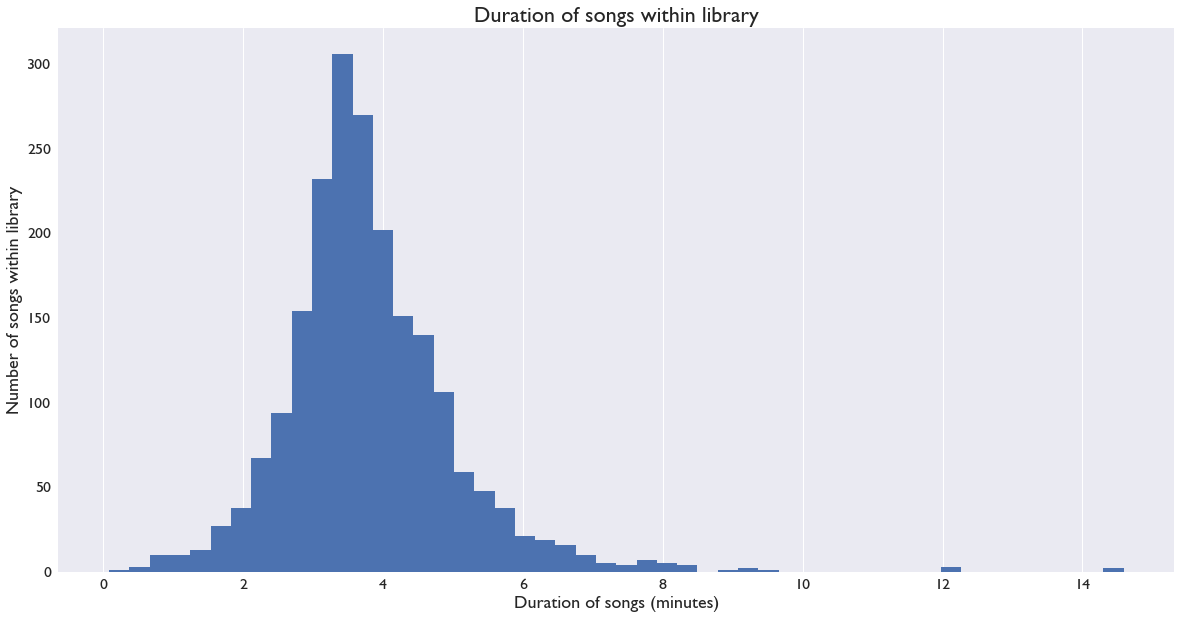

In [189]:
def song_durations():
    library_data["track_duration_minutes"] = library_data["Track Duration"] / 60000
    library_data["track_duration_minutes"].hist(bins=50)
    plt.xlabel('Duration of songs (minutes)', fontsize=18, fontfamily='Gill Sans MT')
    plt.ylabel('Number of songs within library', fontsize=18, fontfamily='Gill Sans MT')
    plt.title('Duration of songs within library', fontsize=22, fontfamily='Gill Sans MT')
    plt.xticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.axes().yaxis.grid()
    plt.show
song_durations()

In [66]:
titles_minutes = library_data[['Title', 'Artist', 'track_duration_minutes']]
titles_minutes[titles_minutes.track_duration_minutes > 10]


,Title,Artist,track_duration_minutes
84,Note to Self,J. Cole,14.588083
217,Mortal Man,Kendrick Lamar,12.118367
227,"Sing About Me, I'm Dying of Thirst",Kendrick Lamar,12.059667
1015,AfricAryaN (feat. Neil deGrasse Tyson),Logic,12.140050
1064,Note to Self,J. Cole,14.588083


A lot of these songs are either towards the end of an album where the artist is doing their tributes and thankyous, or are extended skits/interludes.

In [67]:
library_data["track_duration_seconds"] = library_data["Track Duration"] / 1000
titles_seconds = library_data[['Title', 'Artist', 'track_duration_seconds']]
titles_seconds[titles_seconds.track_duration_seconds < 60]

,Title,Artist,track_duration_seconds
0,The Library (Intro),Childish Gambino,4.812
3,Dial Up,Childish Gambino,44.536
9,Playing Around Before the Party Starts,Childish Gambino,54.454
12,Death By Numbers,Childish Gambino,43.968
47,The Cube (Scene),Logic,27.235
55,Lucidity (Scene),Logic,55.807
86,Kerney Sermon (Skit),J. Cole,46.067
94,Where's Jermaine? (Skit),J. Cole,36.667
161,I Love Kanye,Kanye West,44.827
166,Frank's Track,Kanye West,38.333


A lot of these sub 60 second songs are short interludes between actual songs on an album where the artist tries to do a skit which tries to match the theme of the album (ie. Makes the album more unique and gives it a greater story and continuity)

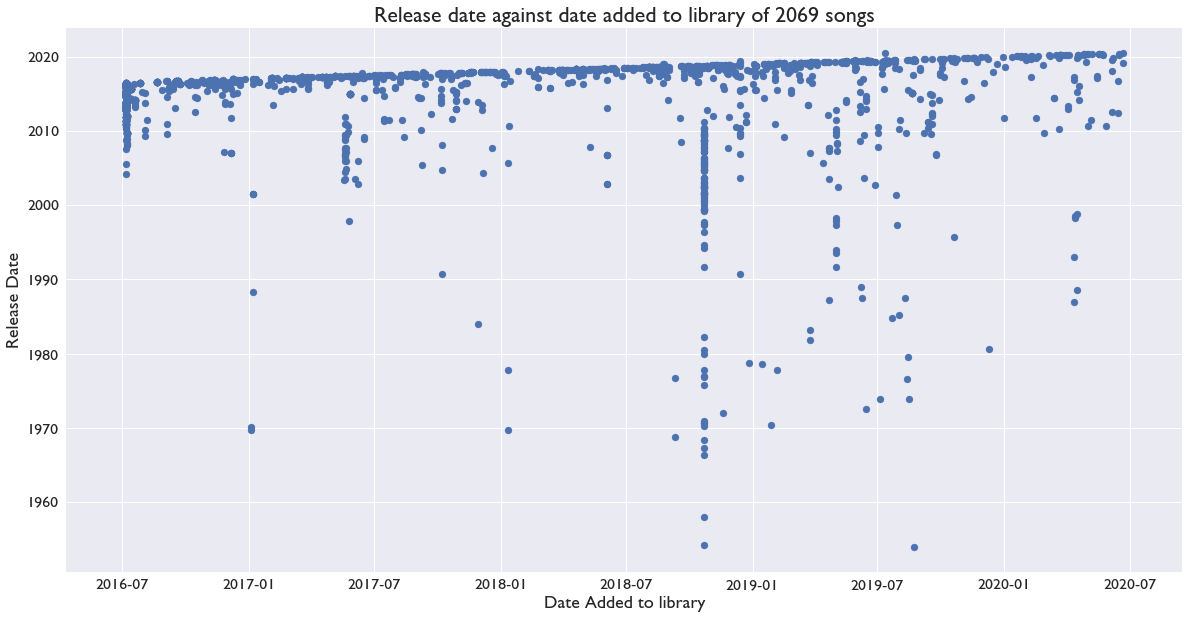

In [223]:
def ReleaseDate_v_DateAdded():
    x=library_data['Date Added To Library']
    y=library_data['Release Date']
    plt.scatter(x, y)
    plt.title('Release date vs date added to library of {} songs'.format(len(library_data)),                    fontsize=22, fontfamily='Gill Sans MT')
    plt.ylabel('Release Date', fontsize=18, fontfamily='Gill Sans MT')
    plt.xlabel('Date Added to library', fontsize=18, fontfamily='Gill Sans MT')
    plt.xticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.grid(True)
    plt.show()

ReleaseDate_v_DateAdded()

In [198]:
pd.options.display.max_columns = None
listening_data

,Apple Id Number,Apple Music Subscription,Artist Name,Build Version,Client IP Address,Content Name,Content Provider,Content Specific Type,Device Identifier,End Position In Milliseconds,End Reason Type,Event End Timestamp,Event Reason Hint Type,Event Received Timestamp,Event Start Timestamp,Event Type,Feature Name,Genre,Item Type,Media Duration In Milliseconds,Media Type,Metrics Bucket Id,Metrics Client Id,Milliseconds Since Play,Offline,Original Title,Play Duration Milliseconds,Source Type,Start Position In Milliseconds,Store Country Name,UTC Offset In Seconds
0,358953842,True,Usher,"Music/3.1 iOS/10.3.1 model/iPhone6,2 hwp/s5l89...",58.168.9.126,U Remind Me,Sony Music,Song,79b330a05a148bd8cc479948ccb6f843db1af063,29198.0,SCRUB_END,2017-05-24T04:45:32.421Z,NOT_SPECIFIED,2017-05-24T04:45:41.139Z,2017-05-24T04:45:07.117Z,PLAY_END,search,R&B/Soul,ITUNES_STORE_CONTENT,266959.0,AUDIO,9459.0,3z4Rpr37z4qOz4dQzAFIz1DqXrfTQc,8718,False,NaN,25304.0,ORIGINATING_DEVICE,3894,Australia,36000
1,358953842,True,Anastacia,"Music/3.1 iOS/12.2 model/iPhone8,1 hwp/s8000 b...",2001:8003:2064:9300:8965:15b6:ca54:d28a,Left Outside Alone,Sony Music,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,1238.0,SCRUB_BEGIN,2019-04-22T01:25:46.439Z,NOT_SPECIFIED,2019-04-22T01:25:48.546Z,2019-04-22T01:25:45.201Z,PLAY_END,search / playlist_detail,Pop,ITUNES_STORE_CONTENT,258856.0,AUDIO,8552.0,3z3LHatpzH4nz4lszA0hz19OoAg8Tl,2107,False,NaN,1238.0,ORIGINATING_DEVICE,0,Australia,36000
2,358953842,True,Coldplay,"Music/3.1 iOS/13.3.1 model/iPhone8,1 hwp/s8000...",2001:8003:30cc:7f00:4b3:cac9:c4ff:afb1,Paradise,The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,1351.0,PLAYBACK_MANUALLY_PAUSED,2020-02-17T03:48:47.549Z,NOT_SPECIFIED,2020-02-17T03:48:48.314Z,2020-02-17T03:48:46.198Z,PLAY_END,library / songs,Alternative,ITUNES_STORE_CONTENT,277664.0,AUDIO,9278.0,3z3NMROKz46xz4SUzAeXz1GOvIePN9,765,False,NaN,1351.0,ORIGINATING_DEVICE,0,Australia,39600
3,358953842,True,Coldplay,"Music/3.1 iOS/13.3.1 model/iPhone8,1 hwp/s8000...",2001:8003:30cc:7f00:60cf:13ba:ea5a:a1e6,Paradise,The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,277664.0,NATURAL_END_OF_TRACK,2020-03-09T08:05:35.179Z,NOT_SPECIFIED,2020-03-09T08:05:35.281Z,2020-03-09T08:00:57.515Z,PLAY_END,library / songs,Alternative,ITUNES_STORE_CONTENT,277664.0,AUDIO,9278.0,3z3NMROKz46xz4SUzAeXz1GOvIePN9,102,False,NaN,277664.0,ORIGINATING_DEVICE,0,Australia,39600
4,358953842,True,Coldplay,"Music/3.1 iOS/13.4.1 model/iPhone8,1 hwp/s8000...",2001:8003:30cc:7f00:7d75:97d5:3cd7:c60c,Paradise,The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,686.0,TRACK_SKIPPED_FORWARDS,2020-06-01T02:04:11.579Z,NOT_SPECIFIED,2020-06-01T02:04:20.803Z,2020-06-01T02:04:10.893Z,PLAY_END,library / songs,Alternative,ITUNES_STORE_CONTENT,277664.0,AUDIO,9278.0,3z3NMROKz46xz4SUzAeXz1GOvIePN9,9224,False,NaN,686.0,ORIGINATING_DEVICE,0,Australia,36000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128732,358953842,True,Drake,"Music/3.0 iOS/10.0.1 model/iPhone6,2 hwp/s5l89...",121.212.120.118,Pop Style,Universal Music International,Song,79b330a05a148bd8cc479948ccb6f843db1af063,213019.0,NATURAL_END_OF_TRACK,2017-01-30T05:32:11.149Z,NOT_SPECIFIED,2017-01-30T05:52:32.073Z,2017-01-30T05:28:38.130Z,PLAY_END,library / albums / album_detail,Hip Hop/Rap,ITUNES_STORE_CONTENT,213019.0,AUDIO,1393.0,3z1Cf16Uz8ltz4r5zBt2z1AfCS6iOS,1220924,True,NaN,213019.0,ORIGINATING_DEVICE,0,Australia,39600
128733,358953842,True,DJ Khaled,"Music/3.1 iOS/10.3.1 model/iPhone6,2 hwp/s5l89...",58.167.58.7,Wild Thoughts (feat. Rihanna & Bryson Tiller),Sony Music,Song,79b330a05a148bd8cc479948ccb6f843db1af063,109301.0,SCRUB_END,2017-06-19T13:31:09.239Z,NOT_SPECIFIED,2017-06-19T13:31:43.634Z,2017-06-19T13:30:31.545Z,PLAY_END,browse / browse / grouping,Hip Hop/Rap,ITUNES_STORE_CONTENT,204242.0,AUDIO,9459.0,3z4Rpr37z4qOz4dQzAFIz1DqXrfTQc,34395,False,NaN,37694.0,ORIGINA

In [72]:
listening_data.columns

Index(['Apple Id Number', 'Apple Music Subscription', 'Artist Name',
       'Build Version', 'Client IP Address', 'Content Name',
       'Content Provider', 'Content Specific Type', 'Device Identifier',
       'End Position In Milliseconds', 'End Reason Type',
       'Event End Timestamp', 'Event Reason Hint Type',
       'Event Received Timestamp', 'Event Start Timestamp', 'Event Type',
       'Feature Name', 'Genre', 'Item Type', 'Media Duration In Milliseconds',
       'Media Type', 'Metrics Bucket Id', 'Metrics Client Id',
       'Milliseconds Since Play', 'Offline', 'Original Title',
       'Play Duration Milliseconds', 'Source Type',
       'Start Position In Milliseconds', 'Store Country Name',
       'UTC Offset In Seconds'],
      dtype='object')

In [73]:
listening_data['End Reason Type'].value_counts()

NATURAL_END_OF_TRACK                         41732
TRACK_SKIPPED_FORWARDS                       33158
PLAYBACK_MANUALLY_PAUSED                     19246
MANUALLY_SELECTED_PLAYBACK_OF_A_DIFF_ITEM    14850
SCRUB_BEGIN                                   7626
SCRUB_END                                     7626
TRACK_SKIPPED_BACKWARDS                       2084
NOT_APPLICABLE                                 116
FAILED_TO_LOAD                                 115
PLAYBACK_STOPPED_DUE_TO_SESSION_TIMEOUT          1
Name: End Reason Type, dtype: int64

In [190]:
full_songs = listening_data[listening_data['End Reason Type'] == 'NATURAL_END_OF_TRACK']
skipped_songs = listening_data[listening_data['End Reason Type'] == 'TRACK_SKIPPED_FORWARDS']

In [76]:
full_songs['Play Duration Milliseconds'].sum() / (1000*60*60*24)

95.19415258101851

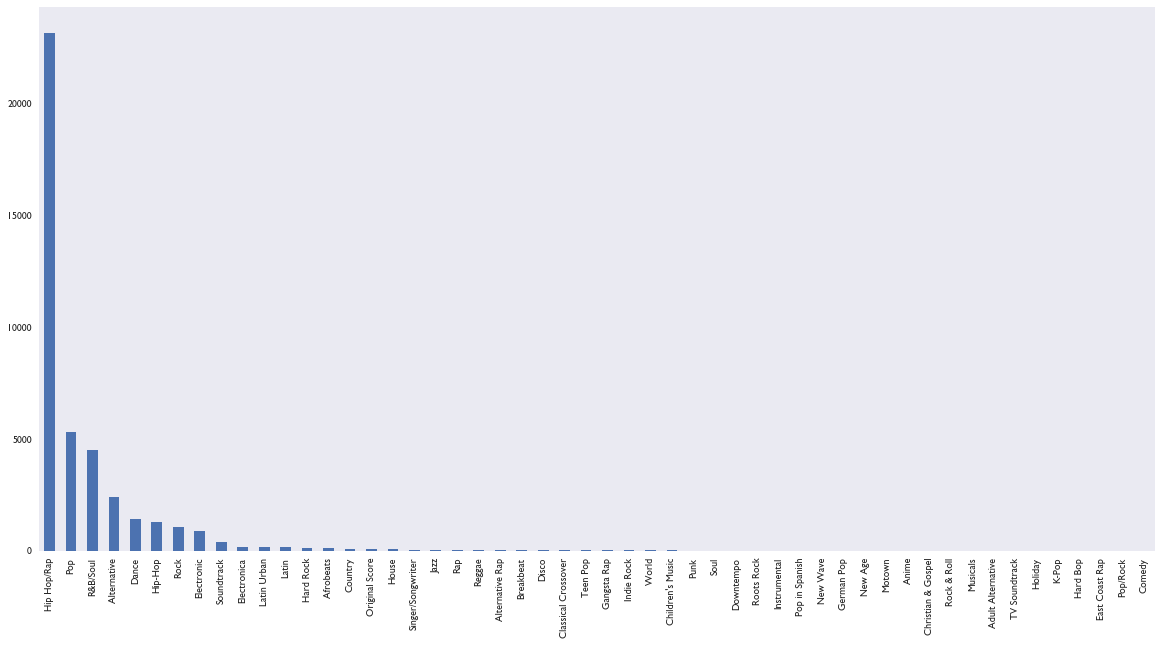

In [196]:
full_songs['Genre'].value_counts().plot(kind='bar')

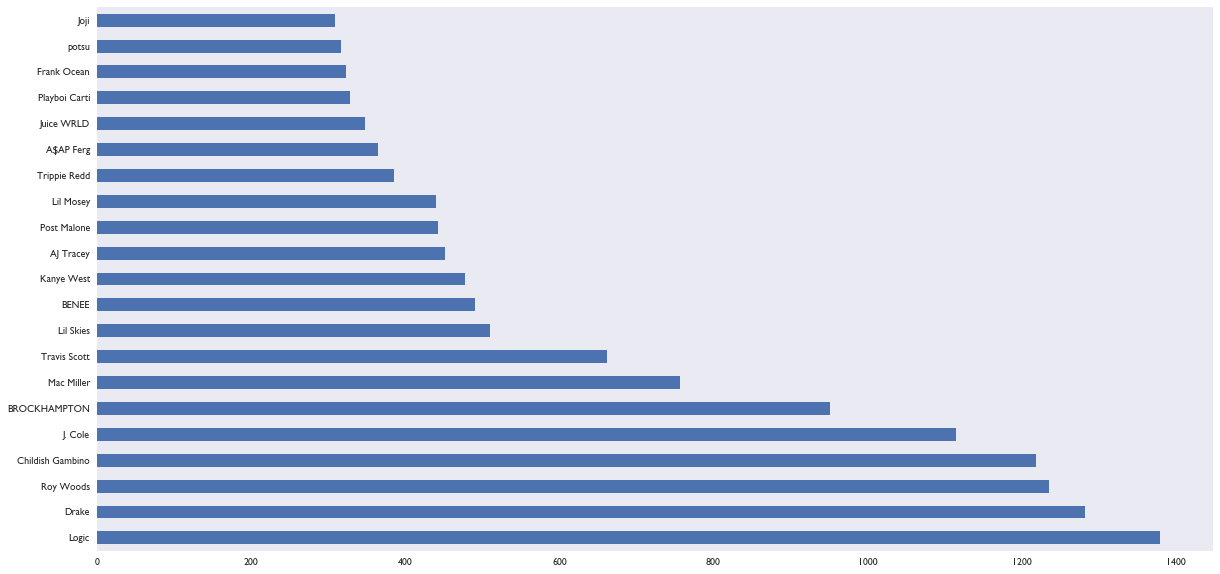

In [195]:
listened_to_artists = full_songs['Artist Name'].value_counts()
listened_to_artists[0:21].plot(kind='barh')

In [79]:
full_songs[['Artist Name', 'Content Name', 'Genre']].iloc[11771]

Artist Name                            Machine Gun Kelly
Content Name    Trap Paris (feat. Quavo & Ty Dolla $ign)
Genre                                        Hip Hop/Rap
Name: 36300, dtype: object

In [80]:
skipped_songs = listening_data[listening_data['End Reason Type'] == 'TRACK_SKIPPED_FORWARDS']
skipped_songs

,Apple Id Number,Apple Music Subscription,Artist Name,Build Version,Client IP Address,Content Name,Content Provider,Content Specific Type,Device Identifier,End Position In Milliseconds,...,Metrics Bucket Id,Metrics Client Id,Milliseconds Since Play,Offline,Original Title,Play Duration Milliseconds,Source Type,Start Position In Milliseconds,Store Country Name,UTC Offset In Seconds
4,358953842,True,Coldplay,"Music/3.1 iOS/13.4.1 model/iPhone8,1 hwp/s8000...",2001:8003:30cc:7f00:7d75:97d5:3cd7:c60c,Paradise,The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,686.0,...,9278.0,3z3NMROKz46xz4SUzAeXz1GOvIePN9,9224,False,NaN,686.0,ORIGINATING_DEVICE,0,Australia,36000
7,358953842,True,MadeinTYO,"Music/3.1 iOS/12.4 model/iPhone8,1 hwp/s8000 b...",120.18.162.126,Lil Bih (feat. 24hrs),The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,316.0,...,4589.0,3z2uIdPHzEsYz59hz9trzygSQbDwM,135,False,NaN,316.0,ORIGINATING_DEVICE,0,Australia,36000
8,358953842,True,Anderson .Paak,"Music/3.1 iOS/12.0 model/iPhone8,1 hwp/s8000 b...",120.18.72.227,Tints (feat. Kendrick Lamar),The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,2936.0,...,3974.0,3z49j34Uz5R4z4iCz9taz1Kn3j664k,228,False,NaN,2936.0,ORIGINATING_DEVICE,0,Australia,39600
9,358953842,True,Logic,"Music/3.1 iOS/12.4.1 model/iPhone8,1 hwp/s8000...",120.18.49.67,Out of Sight,UMG Global,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,279.0,...,4589.0,3z2uIdPHzEsYz59hz9trzygSQbDwM,950737,True,NaN,279.0,ORIGINATING_DEVICE,0,Australia,36000
12,358953842,True,Kendrick Lamar,"Music/3.0 iOS/10.0.1 model/iPhone6,2 hwp/s5l89...",58.166.212.49,i,Universal Music International,Song,79b330a05a148bd8cc479948ccb6f843db1af063,134975.0,...,1393.0,3z1Cf16Uz8ltz4r5zBt2z1AfCS6iOS,2515446,True,NaN,2888.0,ORIGINATING_DEVICE,132087,Australia,39600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128702,358953842,True,Joey Bada$$,"Music/3.1 iOS/11.4.1 model/iPhone8,1 hwp/s8000...",60.227.47.190,TEMPTATION,The Orchard Enterprises Inc.,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,1911.0,...,6999.0,3z4yEJmpzCpFz5G4z93yzXbi1I7UU,492,False,NaN,1911.0,ORIGINATING_DEVICE,0,Australia,36000
128718,358953842,True,Meek Mill,"Music/3.1 iOS/12.3.1 model/iPhone8,1 hwp/s8000...",129.94.8.214,Going Bad (feat. Drake),The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,719.0,...,8552.0,3z3LHatpzH4nz4lszA0hz19OoAg8Tl,1080184,True,NaN,719.0,ORIGINATING_DEVICE,0,Australia,36000
128720,358953842,True,Frank Ocean,"Music/3.1 iOS/13.3 model/iPhone8,1 hwp/s8000 b...",2001:8003:30cc:7f00:d158:58e1:7732:1d7,DHL,"Blonded, LP",Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,0.0,...,4589.0,3z2uIdPHzEsYz59hz9trzygSQbDwM,174,False,NaN,0.0,ORIGINATING_DEVICE,0,Australia,39600
128724,358953842,True,Kendrick Lamar,"Music/3.0 iOS/10.0.1 model/iPhone6,2 hwp/s5l89...",58.164.254.48,Sherane A.K.A Master Splinter’s Daughter,Universal Music International,Song,79b330a05a148bd8cc479948ccb6f843db1af063,813.0,...,1393.0,3z1Cf16Uz8ltz4r5zBt2z1AfCS6iOS,44,False,NaN,813.0,ORIGINATING_DEVICE,0,Australia,39600


In [174]:
skipped = skipped_songs['Content Name'].value_counts()
skipped.iloc[0:16]

Intro                           79
Location                        64
03' Adolescence                 63
A Tale of 2 Citiez              63
The Show Goes On                60
Fire Squad                      59
St. Tropez                      58
Blessings (feat. Drake)         56
Be Yourself                     56
lose                            56
beibs in the trap               54
Hello                           54
Swipe Life (feat. Rick Ross)    53
Skin                            52
Stay                            52
Death By Numbers                50
Name: Content Name, dtype: int64

In [83]:
library_data[(library_data['Track Count On Album'] == 1) & (library_data['Track Number On Album'] == 1)]
#These are all the singles in my library


,Content Type,Track Identifier,Title,Sort Name,Artist,Sort Artist,Is Part of Compilation,Album,Sort Album,Album Artist,...,Skip Count,Date of Last Skip,Is Purchased,Audio File Extension,Is Checked,Copyright,Release Date,Purchased Track Identifier,Apple Music Track Identifier,Composer
103,Song,182859274,Know Me From,Know Me From,Stormzy,Stormzy,False,Know Me From - Single,Know Me From - Single,Stormzy,...,2,2018-05-12T05:34:30Z,False,m4a,False,℗ 2015 Stormzy,2015-03-08T00:00:00Z,9.728678e+08,9.728678e+08,NaN
150,Song,182860062,Peso,Peso,A$AP Rocky,A$AP Rocky,False,Peso - Single,Peso - Single,A$AP Rocky,...,1,2017-01-03T02:09:30Z,False,m4a,False,℗ 2011 A$AP Rocky Recordings LLC/RCA Records. ...,2011-10-31T00:00:00Z,4.814880e+08,4.814880e+08,"James Harris, Rakim Mayers, Terry Lewis & Tysh..."
151,Song,182860066,Multiply (feat. Juicy J),Multiply (feat. Juicy J),A$AP Rocky,A$AP Rocky,False,Multiply (feat. Juicy J) - Single,Multiply (feat. Juicy J) - Single,A$AP Rocky,...,4,2018-03-03T20:21:34Z,False,m4a,False,℗ 2014 A$AP Rocky Recordings LLC/RCA Records. ...,2014-10-03T00:00:00Z,9.255036e+08,9.255036e+08,"Rakim Mayers, Anthony Lamont Wharton II, Jorda..."
152,Song,182860070,"Everyday (feat. Rod Stewart, Miguel & Mark Ron...","Everyday (feat. Rod Stewart, Miguel & Mark Ron...",A$AP Rocky,A$AP Rocky,False,"Everyday (feat. Rod Stewart, Miguel & Mark Ron...","Everyday (feat. Rod Stewart, Miguel & Mark Ron...",A$AP Rocky,...,0,NaN,False,m4a,False,℗ 2015 A$AP Rocky Recordings LLC/RCA Records,2015-05-08T00:00:00Z,9.930192e+08,9.930192e+08,"Mark Ronson, Rakim Mayers, Miguel & David Keit..."
196,Song,182860846,"See Me Now (feat. Big Sean, Beyoncé & Charlie ...","See Me Now (feat. Big Sean, Beyoncé & Charlie ...",Kanye West,Kanye West,False,My Beautiful Dark Twisted Fantasy,My Beautiful Dark Twisted Fantasy,Kanye West,...,0,NaN,False,m4a,False,"℗ 2010 Roc-A-Fella Records, LLC",2010-11-22T04:00:00Z,4.039689e+08,4.039689e+08,"Ernest Wilson, Kanye West, Beyoncé Knowles, Br..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050,Song,182894862,Say It Again (feat. A$AP Ferg),Say It Again (feat. A$AP Ferg),Onefour,Onefour,False,Say It Again (feat. A$AP Ferg) - Single,Say It Again (feat. A$AP Ferg) - Single,Onefour,...,0,NaN,False,m4a,False,℗ 2020 ONEFOUR,2020-05-06T00:00:00Z,1.511196e+09,1.511196e+09,"Spencer Magalogo, Jerome Misa & Darold Brown"
2052,Song,182894870,Feel the Way I Do,Feel the Way I Do,The Jungle Giants,Jungle Giants,False,Feel the Way I Do - Single,Feel the Way I Do - Single,The Jungle Giants,...,0,NaN,False,m4a,False,℗ 2017 Amplifire Music,2017-01-31T04:00:00Z,1.198928e+09,1.198928e+09,NaN
2056,Song,182894886,What It Is,What It Is,KYLE,KYLE,False,What It Is - Single,What It Is - Single,KYLE,...,0,NaN,False,m4a,False,℗ 2020 independently popular. under exclusive ...,2020-05-18T00:00:00Z,1.512190e+09,1.512190e+09,Kyle Harvey & Mick Schultz
2065,Song,182895122,Rover (feat. DTG),Rover (feat. DTG),S1mba,S1mba,False,Rover (feat. DTG) - Single,Rover (feat. DTG) - Single,S1mba,...,0,NaN,False,m4a,False,℗ 2020 Rax Productions Limited under exclusive...,2020-03-04T00:00:00Z,1.501569e+09,1.501569e+09,"Ayodeji Araoye, Leonard Simbarashe Rwodzi & Ty..."
